# Libraries used


In [ ]:
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb
from IPython.display import clear_output

In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d abhisheksjha/time-series-air-quality-data-of-india-2010-2023


Dataset URL: https://www.kaggle.com/datasets/abhisheksjha/time-series-air-quality-data-of-india-2010-2023
License(s): CC-BY-NC-SA-4.0
User cancelled operation
Exception ignored in: <finalize object at 0x7e2060512560; dead>
Traceback (most recent call last):
  File "/usr/lib/python3.11/weakref.py", line 585, in __call__
    def __call__(self, _=None):

KeyboardInterrupt: 


## Loading the data


In [ ]:

!unzip time-series-air-quality-data-of-india-2010-2023.zip -d air_quality_data



Archive:  time-series-air-quality-data-of-india-2010-2023.zip
replace air_quality_data/AP001.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
os.listdir('air_quality_data')[:10]


['BR005.csv',
 'WB011.csv',
 'UP007.csv',
 'BR021.csv',
 'KA039.csv',
 'UP017.csv',
 'MH016.csv',
 'RJ006.csv',
 'WB001.csv',
 'AP006.csv']

In [ ]:
import pandas as pd

stations_df = pd.read_csv("air_quality_data/stations_info.csv")
stations_df.drop(columns=['agency', 'station_location', 'start_month'], inplace=True, errors='ignore')
stations_df.head()


,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [ ]:
def combine_state_df(state_name):
    '''
    Combine air quality data from up to 100 cities of a given state,
    adding city and state columns to each row.

    Parameters
    ----------
        state_name (str): The name of the state

    Returns
    -------
        DataFrame: Combined dataframe from selected files with city and state columns added
    '''
    # Filter stations for the selected state
    state_stations = stations_df[stations_df['state'] == state_name]

    # Limit to top 100 unique cities
    top_cities = state_stations['city'].unique()[:100]

    # Subset stations for only those cities
    limited_stations = state_stations[state_stations['city'].isin(top_cities)]

    # Get corresponding file names for those stations
    allowed_file_names = limited_stations['file_name'].unique()

    # Find matching CSV files in your directory
    state_files = [
        f for f in glob.glob("air_quality_data/*.csv")
        if not f.endswith("stations_info.csv") and os.path.splitext(os.path.basename(f))[0] in allowed_file_names
    ]

    print(f'Combining data from {len(state_files)} files for up to 100 cities in {state_name}...\n')

    combined_df = []

    for state_file in state_files:
        file_name = os.path.splitext(os.path.basename(state_file))[0]

        # Read the file
        file_df = pd.read_csv(state_file)

        # Get city and state info for this file from stations_df
        station_info = limited_stations[limited_stations['file_name'] == file_name].iloc[0]

        # Add city and state columns to this file's dataframe
        file_df['city'] = station_info['city']
        file_df['state'] = station_info['state']

        combined_df.append(file_df)

    # Combine all dataframes
    return pd.concat(combined_df, ignore_index=True)


In [ ]:
df = combine_state_df('Delhi')
df.info()


Combining data from 40 files for up to 100 cities in Delhi...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796171 entries, 0 to 2796170
Data columns (total 61 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  BP (mmHg)            float64
 19  Xylene (ug/m3)       float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  cit

# Label Creation


In [ ]:
def calculate_risk_level(row):
    score = 0

    # --- Air quality impact ---
    if row['PM2.5 (ug/m3)'] > 150:
        score += 2
    elif row['PM2.5 (ug/m3)'] > 75:
        score += 1

    if row['PM10 (ug/m3)'] > 200:
        score += 2
    elif row['PM10 (ug/m3)'] > 100:
        score += 1

    if row['NO (ug/m3)'] > 80:
        score += 1

    if row['NO2 (ug/m3)'] > 100:
        score += 2
    elif row['NO2 (ug/m3)'] > 50:
        score += 1

    if row['NOx (ppb)'] > 200:
        score += 2
    elif row['NOx (ppb)'] > 100:
        score += 1

    if row['NH3 (ug/m3)'] > 400:
        score += 2
    elif row['NH3 (ug/m3)'] > 200:
        score += 1

    if row['SO2 (ug/m3)'] > 80:
        score += 1

    if row['CO (mg/m3)'] > 4:
        score += 2
    elif row['CO (mg/m3)'] > 2:
        score += 1

    if row['Ozone (ug/m3)'] > 180:
        score += 2
    elif row['Ozone (ug/m3)'] > 100:
        score += 1

    if row['Benzene (ug/m3)'] > 5:
        score += 1

    if row['Toluene (ug/m3)'] > 100:
        score += 1

    # --- Personal risk amplifiers ---
    if row['age'] > 60 or row['age'] < 10:
        score += 1
    if row.get('smoker', False):
        score += 1
    if row.get('time_outside_hours', 0) > 4:
        score += 1

    # Pre-existing conditions
    conditions = str(row.get('pre_existing_condition', '')).lower()
    risk_conditions = ['none', 'asthma', 'COPD', 'bronchitis', 'lung cancer', 'heart disease', 'diabetes', 'allergies']
    if any(risk_cond in conditions for risk_cond in risk_conditions):
        score += 2

    # --- Risk level assignment ---
    if score >= 5:
        return 'Very High'
    elif score >= 3:
        return 'High'
    elif score == 2:
        return 'Moderate'
    else:
        return 'Low'


# User Profile

In [ ]:
user_profile = {
    'age': 45,                   # integer (0-80)
    'smoker': True,              # boolean (True/False)
    'pre_existing_condition': 'asthma',  # categorical: 'asthma', 'COPD', 'none'
    'time_outside_hours': 6,     # integer/float (0-10)
    'mask_usage': False          # boolean (True/False)
}


## Synthetic Profile Creation

In [ ]:
import random

def generate_random_user():
    age = random.randint(0, 80)
    smoker = random.choice([True, False])
    pre_condition = random.choices(
    ['none', 'asthma', 'COPD', 'bronchitis', 'lung cancer', 'heart disease', 'diabetes', 'allergies'],
    weights=[0.5, 0.15, 0.1, 0.07, 0.05, 0.06, 0.04, 0.03]
)[0]

    time_outside = round(random.uniform(0, 10), 1)
    mask_usage = random.choice([True, False])

    return {
        'age': age,
        'smoker': smoker,
        'pre_existing_condition': pre_condition,
        'time_outside_hours': time_outside,
        'mask_usage': mask_usage
    }

synthetic_users = []
for _ in range(1000000):
    synthetic_users.append(generate_random_user())

# Example:
for _ in range(5):
    print(generate_random_user())


{'age': 18, 'smoker': True, 'pre_existing_condition': 'diabetes', 'time_outside_hours': 3.1, 'mask_usage': False}
{'age': 25, 'smoker': False, 'pre_existing_condition': 'bronchitis', 'time_outside_hours': 8.1, 'mask_usage': False}
{'age': 10, 'smoker': False, 'pre_existing_condition': 'COPD', 'time_outside_hours': 0.1, 'mask_usage': True}
{'age': 44, 'smoker': False, 'pre_existing_condition': 'none', 'time_outside_hours': 4.1, 'mask_usage': True}
{'age': 46, 'smoker': True, 'pre_existing_condition': 'allergies', 'time_outside_hours': 3.2, 'mask_usage': False}


# Convert Synthetic users to data frame

In [ ]:
import pandas as pd
user_df = pd.DataFrame(synthetic_users)


In [ ]:
# Calculate the fraction of NaNs per column
nan_fraction = df.isna().mean()

# Select columns where NaN fraction is less than or equal to 0.5 (i.e., keep columns with <= 50% NaNs)
cols_to_keep = nan_fraction[nan_fraction <= 0.5].index

# Filter the dataframe to keep only those columns
df = df[cols_to_keep]

print(f"Columns after removing those with >50% NaNs: {df.shape[1]}")
df = df.sample(n=1000000, random_state=42).reset_index(drop=True)


Columns after removing those with >50% NaNs: 18


In [ ]:
import pandas as pd
combined_df = pd.concat([user_df, df.reset_index(drop=True)], axis=1)
combined_df.head()

,age,smoker,pre_existing_condition,time_outside_hours,mask_usage,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),...,SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),RH (%),WS (m/s),city,state,SR (W/mt2)
0,34,False,none,9.6,True,2020-10-29 07:00:00,2020-10-29 08:00:00,431.75,828.25,261.40,...,21.98,3.50,26.45,NaN,NaN,72.38,NaN,Delhi,Delhi,99.97
1,37,True,none,1.8,True,2020-05-15 02:00:00,2020-05-15 03:00:00,39.00,95.50,0.60,...,11.70,1.10,10.77,1.18,2.38,56.35,1.95,Delhi,Delhi,3.62
2,22,True,none,5.7,False,2012-09-12 16:00:00,2012-09-12 17:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Delhi,Delhi,NaN
3,37,False,COPD,6.7,False,2018-02-22 05:00:00,2018-02-22 06:00:00,301.00,691.25,111.42,...,45.85,3.93,3.00,75.87,8.17,82.92,0.30,Delhi,Delhi,12.25
4,79,False,none,3.5,True,2020-01-19 09:00:00,2020-01-19 10:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Delhi,Delhi,NaN


In [ ]:
combined_df.shape[0]

1000000

# Model Training

In [ ]:
user_profile = {
    'age': 35,
    'smoker': False,
    'condition': 'none',  # or 'asthma', 'copd', etc.
    'time_outside': 3,    # in hours per day
    'mask_usage': 'yes'
}


In [ ]:
import pandas as pd

chunk_size = 50000  # adjust based on your memory
results = []

for start in range(0, len(combined_df), chunk_size):
    end = start + chunk_size
    chunk = combined_df.iloc[start:end].copy()
    chunk['Risk Level'] = chunk.apply(calculate_risk_level, axis=1)
    results.append(chunk)

# Combine all chunks
final_df = pd.concat(results, ignore_index=True)



In [ ]:
final_df.to_csv('combined_air_quality_with_risk.csv', index=False)


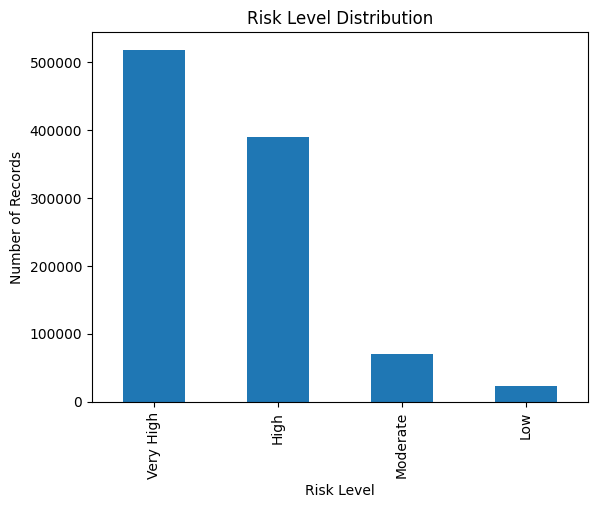

In [ ]:
import matplotlib.pyplot as plt

final_df['Risk Level'].value_counts().plot(kind='bar')
plt.title('Risk Level Distribution')
plt.xlabel('Risk Level')
plt.ylabel('Number of Records')
plt.show()


In [ ]:
final_df.head()

,age,smoker,pre_existing_condition,time_outside_hours,mask_usage,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),...,CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),RH (%),WS (m/s),city,state,SR (W/mt2),Risk Level
0,34,False,none,9.6,True,2020-10-29 07:00:00,2020-10-29 08:00:00,431.75,828.25,261.40,...,3.50,26.45,NaN,NaN,72.38,NaN,Delhi,Delhi,99.97,Very High
1,37,True,none,1.8,True,2020-05-15 02:00:00,2020-05-15 03:00:00,39.00,95.50,0.60,...,1.10,10.77,1.18,2.38,56.35,1.95,Delhi,Delhi,3.62,High
2,22,True,none,5.7,False,2012-09-12 16:00:00,2012-09-12 17:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Delhi,Delhi,NaN,High
3,37,False,COPD,6.7,False,2018-02-22 05:00:00,2018-02-22 06:00:00,301.00,691.25,111.42,...,3.93,3.00,75.87,8.17,82.92,0.30,Delhi,Delhi,12.25,Very High
4,79,False,none,3.5,True,2020-01-19 09:00:00,2020-01-19 10:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Delhi,Delhi,NaN,High


In [ ]:
final_df['From Date'] = pd.to_datetime(final_df['From Date'])
final_df['To Date'] = pd.to_datetime(final_df['To Date'])

# Duration
final_df['exposure_duration_hr'] = (final_df['To Date'] - final_df['From Date']).dt.total_seconds() / 3600

# Season
def get_season(dt):
    month = dt.month
    if month in [12, 1, 2]: return 'winter'
    elif month in [3, 4, 5]: return 'spring'
    elif month in [6, 7, 8]: return 'summer'
    else: return 'autumn'

final_df['season'] = final_df['From Date'].apply(get_season)

In [ ]:
# Aggregate pollutants (can normalize later)
pollutant_cols = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
                  'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
                  'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)']

final_df['aqi_avg'] = final_df[pollutant_cols].mean(axis=1)
final_df['aqi_max'] = final_df[pollutant_cols].max(axis=1)
final_df['aqi_std'] = final_df[pollutant_cols].std(axis=1)

In [ ]:
final_df['mask_score'] = final_df['mask_usage'].map({"False": 0, "True": 1})
final_df['is_smoker'] = final_df['smoker'].map({'False': 0, 'True': 1})

# # Convert conditions into binary columns
# conditions =[ 'asthma', 'COPD', 'bronchitis', 'lung cancer', 'heart disease', 'diabetes', 'allergies']

# for cond in conditions:
#     final_df[cond.replace(' ', '_').lower()] = final_df['pre_existing_condition'].apply(
#         lambda x: 1 if cond in x else 0
#     )

In [ ]:
print(list(final_df.columns))



['age', 'smoker', 'pre_existing_condition', 'time_outside_hours', 'mask_usage', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'RH (%)', 'WS (m/s)', 'city', 'SR (W/mt2)', 'Risk Level', 'exposure_duration_hr', 'season', 'aqi_avg', 'aqi_max', 'aqi_std']


In [ ]:
final_df.head()

,age,smoker,pre_existing_condition,time_outside_hours,mask_usage,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),...,RH (%),WS (m/s),city,SR (W/mt2),Risk Level,exposure_duration_hr,season,aqi_avg,aqi_max,aqi_std
0,34,False,none,9.6,True,431.75,828.25,261.40,66.50,248.53,...,72.38,NaN,Delhi,99.97,Very High,1.0,autumn,214.956667,828.25,272.580771
1,37,True,none,1.8,True,39.00,95.50,0.60,8.85,4.70,...,56.35,1.95,Delhi,3.62,High,1.0,spring,16.507273,95.50,28.353874
2,22,True,none,5.7,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Delhi,NaN,High,1.0,autumn,NaN,NaN,NaN
3,37,False,COPD,6.7,False,301.00,691.25,111.42,101.12,95.17,...,82.92,0.30,Delhi,12.25,Very High,1.0,winter,132.155455,691.25,204.020870
4,79,False,none,3.5,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Delhi,NaN,High,1.0,winter,NaN,NaN,NaN


In [ ]:
final_df.to_csv('combined_air_quality_with_risk.csv', index=False)


In [ ]:
# Define AQI categories (can adjust based on domain knowledge)
def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

final_df['aqi_category'] = final_df['aqi_avg'].apply(categorize_aqi)

# Now group by AQI category and season
grouped = final_df.groupby(['aqi_category', 'season'])


In [ ]:


from sklearn.ensemble import IsolationForest

# Assuming df has pollution features
features = final_df[ [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
    'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
    'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)'
]]  # use the correct feature columns
model = IsolationForest(contamination=0.01)
final_df['anomaly_col'] = model.fit_predict(features)  # assign here

# Now you can access df['anomaly_col'] without error
print(final_df['anomaly_col'].head())


0    1
1    1
2    1
3   -1
4    1
Name: anomaly_col, dtype: int64


In [ ]:
alerts_df = final_df[
    (final_df['PM2.5 (ug/m3)'] > 250) |
    (final_df['anomaly_col']) |
    (final_df['aqi_avg'] > 300)
]


In [ ]:
print(df['anomaly_col'].value_counts())


anomaly_col
 1    990000
-1     10000
Name: count, dtype: int64


# visualising anomalies

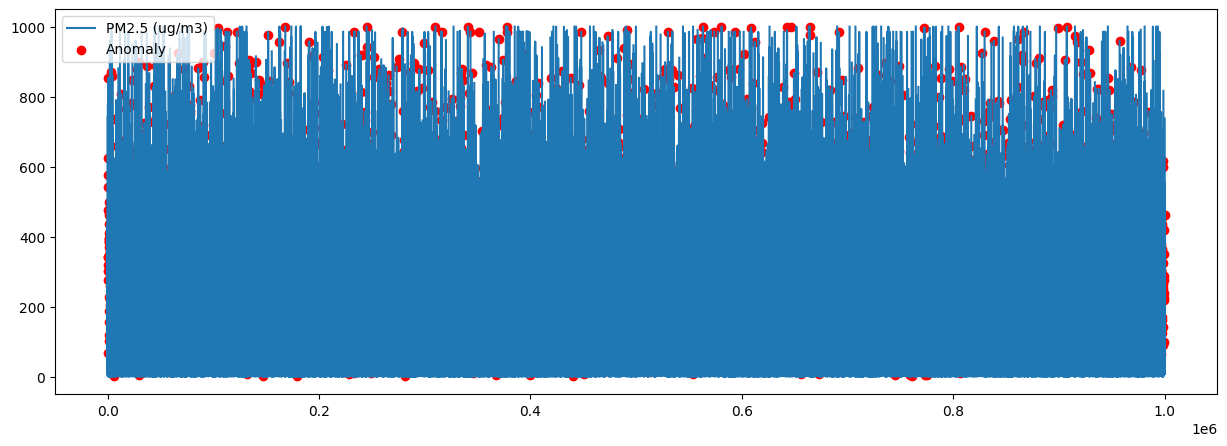

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(final_df['PM2.5 (ug/m3)'], label='PM2.5 (ug/m3)')
plt.scatter(final_df.index[final_df['anomaly_col'] == -1], final_df['PM2.5 (ug/m3)'][final_df['anomaly_col'] == -1], color='red', label='Anomaly')
plt.legend()
plt.show()


In [ ]:
features = [
   'age', 'smoker', 'pre_existing_condition', 'time_outside_hours', 'mask_usage', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'RH (%)', 'WS (m/s)', 'city', 'SR (W/mt2)', 'Risk Level', 'exposure_duration_hr', 'season', 'aqi_avg', 'aqi_max', 'aqi_std']

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
final_df['Risk Level Encoded'] = le.fit_transform(final_df['Risk Level'])  # low=1, medium=2, high=3



# Train nd Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X = final_df[features]
X = pd.get_dummies(X)  # for season, smoker, etc.

# Choose target: Either classification or regression
y = final_df['Risk Level Encoded']  # for classification
# y = final_df['risk_score']        # for regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model Training

In [133]:
from xgboost import XGBClassifier, XGBRegressor

# Classification
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # or 'logloss' for binary
# model = XGBRegressor()  # Uncomment for regression

model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:01:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [134]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

y_pred = model.predict(X_test)

# Classification
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Regression
# mse = mean_squared_error(y_test, y_pred)
# print(f"RMSE: {mse ** 0.5:.2f}")


Accuracy: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     77863
         Low       1.00      1.00      1.00      4674
    Moderate       1.00      1.00      1.00     14107
   Very High       1.00      1.00      1.00    103356

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [135]:
import joblib
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


NameError: name 'xgb_model' is not defined